#  Inventory Optimization Analysis

###  Objective

To analyze raw material procurement data, identify overstocked and underutilized items, and recommend actions to reduce inventory holding costs.

---

## 1.  Import Libraries & Load Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# load data set
df = pd.read_csv("./data/full_data/data.csv")

/tmp/ipykernel_5784/1588343676.py:8: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/full_data/data.csv")


## 2.  Data Cleaning

- Check for missing values
- Check for duplicate entries
- Ensure correct data types


In [2]:
# Drop duplicates
print("duplicate rows : ", df.duplicated().sum())
df.drop_duplicates(inplace=True)

# manage data types of columns
# converting date formats
df["Entry Date"] = pd.to_datetime(df["Entry Date"], format="%d-%m-%Y")
df["Document Date"] = pd.to_datetime(df["Document Date"], format="%d-%m-%Y")

df["Time of Entry"] = pd.to_datetime(df["Time of Entry"], format="%I:%M:%S %p").dt.time

# convert consumption as a boolean value
df["Consumption"] = df["Consumption"].notna().astype(int)

# remove comma for numbers
cols_to_convert = [
    "Qty in Un. of Entry",
    "Qty in order unit",
    "Quantity",
    "Amount in LC",
]
for col in cols_to_convert:
    df[col] = df[col].str.replace(",", "", regex=False)
    df[col] = pd.to_numeric(df[col], errors="coerce")

# info
df.info()
df.isnull().sum()

duplicate rows :  341
<class 'pandas.core.frame.DataFrame'>
Index: 61226 entries, 0 to 61566
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Material              61226 non-null  int64         
 1   Material Description  61226 non-null  object        
 2   Plant                 61226 non-null  int64         
 3   Storage Location      58076 non-null  object        
 4   Movement Type         61226 non-null  int64         
 5   Posting Date          61226 non-null  object        
 6   Qty in Un. of Entry   61226 non-null  float64       
 7   Unit of Entry         61226 non-null  object        
 8   Batch                 797 non-null    float64       
 9   Order                 21470 non-null  float64       
 10  Movement Type Text    61226 non-null  object        
 11  Document Date         61226 non-null  datetime64[ns]
 12  Qty in OPUn           61226 non-null  object        
 13 

Material                    0
Material Description        0
Plant                       0
Storage Location         3150
Movement Type               0
Posting Date                0
Qty in Un. of Entry         0
Unit of Entry               0
Batch                   60429
Order                   39756
Movement Type Text          0
Document Date               0
Qty in OPUn                 0
Order Price Unit        36338
Order Unit              36332
Qty in order unit           0
Entry Date                  0
Time of Entry               0
Amount in LC                0
Purchase Order          36244
Item                        0
Cost Center             33248
Movement indicator      36332
Consumption                 0
Supplier                36251
Base Unit of Measure        0
Quantity                    0
Material Doc. Year          0
Debit/Credit ind            0
User name                   0
Trans./Event Type           0
Currency                    0
Material Type               0
Vendor Cod

## 3. Exploratory Data Analysis (EDA)

Let's analyze:

- Top purchased materials
- Top consumed materials
- Top overstocked materials
- Monthly procurement vs consumption
- Inventory turnover trends


In [66]:
total_n_materials = df["Material"].nunique()
total_n_material_descriptions = df["Material Description"].nunique()
df["Material"].value_counts().reset_index()
df["Material Description"].value_counts().reset_index()
df[["Material", "Material Description"]].value_counts().reset_index()

,Material,Material Description,count
0,31033204,FURNACE OIL,2061
1,31004367,THERMAL PAPER PALL INTEGRITY PRINTER ROL,339
2,31002569,MICROLITERTIPS 200-1000UL(TARSON-521020P,295
3,31002568,MICROLITER TIPS 2-200UL(TARSONS-521010P),222
4,31080045,Furnace oil,222
...,...,...,...
10543,31081103,"Power safety relay,Make:Phoenix contact,",1
10544,31081072,"Isolator, Make: Radix, Model:SCC311,Orde",1
10545,31081570,"CPU, Make: Siemens, P/N:6ES7511-1AK02-0A",1
10546,31081883,CONDENSING FAN MOTOR( RT ) for Freezer M,1


In [68]:
total_n_materials

10548

In [67]:
total_n_material_descriptions

10167

In [3]:
"""
movement_type_classification = {
    "Purchased": {
        101: "GR goods receipt",
        101.1: "GR for acct assgmnt",       # same type, different text
        101.2: "GR stock in transit",
    },
    "Consumed": {
        201: "GI for cost center",
        202: "RE for cost center",
        261: "GI for order",
    },
    "Other": {
        102: "GR for PO reversal",
        102.1: "GR for acc.assgt rev",
        161: "GR returns",
        301: "TF transfer plant to plant",
        309: "TF tfr ps.mat.to mat",
        311: "TF transfer within plant",
        321: "TF quality to unrest",
        641: "TF to stock in transit",
    }
}
"""

'\nmovement_type_classification = {\n    "Purchased": {\n        101: "GR goods receipt",\n        101.1: "GR for acct assgmnt",       # same type, different text\n        101.2: "GR stock in transit",\n    },\n    "Consumed": {\n        201: "GI for cost center",\n        202: "RE for cost center",\n        261: "GI for order",\n    },\n    "Other": {\n        102: "GR for PO reversal",\n        102.1: "GR for acc.assgt rev",\n        161: "GR returns",\n        301: "TF transfer plant to plant",\n        309: "TF tfr ps.mat.to mat",\n        311: "TF transfer within plant",\n        321: "TF quality to unrest",\n        641: "TF to stock in transit",\n    }\n}\n'

In [4]:
movement_type_classification = {
    "Purchased": [101],  # Goods receipt
    # Goods issue to cost center, reversal, production
    "Consumed": [201, 202, 261],
    "Other": [102, 161, 301, 309, 311, 321, 641],  # Returns, transfers, etc.
}

movement_type_to_label = {
    code: label
    for label, codes in movement_type_classification.items()
    for code in codes
}

df["Movement Category"] = df["Movement Type"].map(movement_type_to_label).fillna("NA")

In [5]:
# Export
# df.to_csv("./data/full_data/clean_data.csv", index = False)

In [6]:
materials_purchased = (
    df[df["Movement Category"] == "Purchased"]
    .groupby(["Material", "Material Description"])[["Quantity", "Amount in LC"]]
    .sum()
    .reset_index()
)

materials_consumed = (
    df[df["Movement Category"] == "Consumed"]
    .groupby(["Material", "Material Description"])[["Quantity", "Amount in LC"]]
    .sum()
    .abs()
    .reset_index()
)

In [7]:
top_10_materials_purchased = materials_purchased.sort_values(
    by="Quantity", ascending=False
).head(10)

top_10_materials_consumed = (
    materials_consumed.sort_values(by="Quantity", ascending=False)
    .reset_index(drop=True)
    .head(10)
)

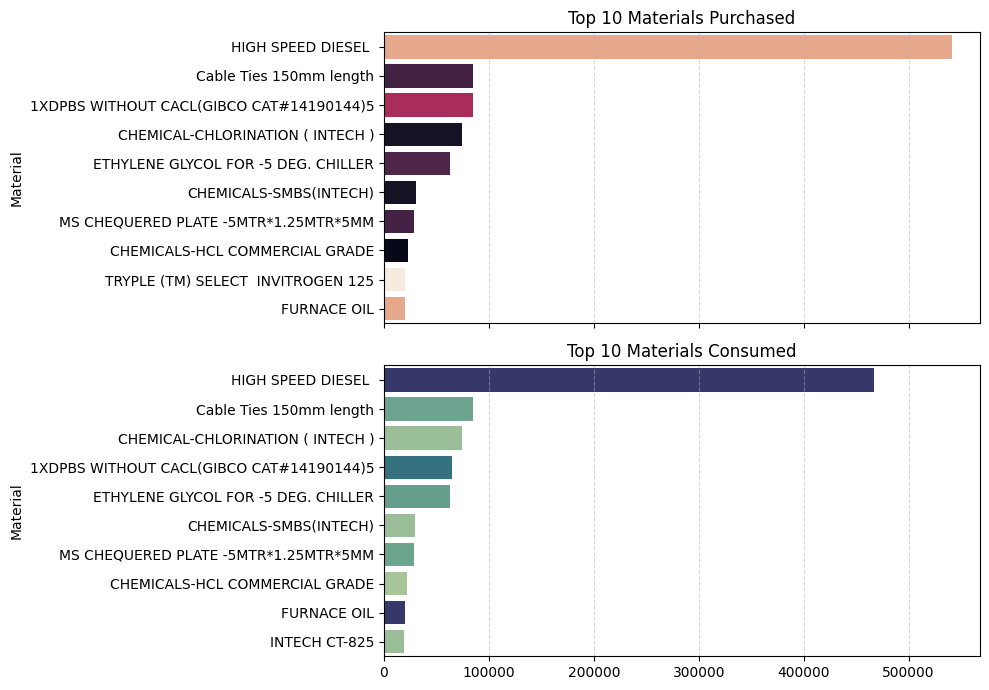

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharex=True)


plot_purchase = sns.barplot(
    data=top_10_materials_purchased,
    y="Material Description",
    x="Quantity",
    ax=axes[0],
    hue="Material",
    palette="rocket",
    legend=False,
)
axes[0].set_title("Top 10 Materials Purchased")
axes[0].set_ylabel("Material")
axes[0].set_xlabel("Quantity")

plot_consumed = sns.barplot(
    data=top_10_materials_consumed,
    y="Material Description",
    x="Quantity",
    ax=axes[1],
    hue="Material",
    palette="crest",
    legend=False,
)
axes[1].set_title("Top 10 Materials Consumed")
axes[1].set_ylabel("Material")
axes[1].set_xlabel("")

axes[0].grid(True, axis="x", linestyle="--", alpha=0.5)
axes[1].grid(True, axis="x", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [9]:
materails_full = pd.merge(
    materials_purchased.rename(
        columns={"Quantity": "Purchase Quantity", "Amount in LC": "Purchase Amount"}
    ),
    materials_consumed.rename(
        columns={"Quantity": "Consumed Quantity", "Amount in LC": "Consumed Amount"}
    ),
    on=["Material", "Material Description"],
    how="outer",
).fillna(0)

In [10]:
materails_full["Net quantity"] = (
    materails_full["Purchase Quantity"] - materails_full["Consumed Quantity"]
)

In [11]:
materails_full.sort_values(by="Net quantity", ascending=False)

,Material,Material Description,Purchase Quantity,Purchase Amount,Consumed Quantity,Consumed Amount,Net quantity
3748,31033202,HIGH SPEED DIESEL,541000.0,53505330.00,466875.0,45640193.85,74125.0
4301,31039950,TRYPLE (TM) SELECT INVITROGEN 125,20500.0,437937.85,0.0,0.00,20500.0
2754,31020588,1XDPBS WITHOUT CACL(GIBCO CAT#14190144)5,84500.0,365534.90,65000.0,281892.50,19500.0
2297,31016575,DNA-50-4 OLIGO,15730.0,222196.00,2092.0,31380.00,13638.0
2285,31016419,WISTER RATS,13354.0,21169864.00,2114.0,3321168.00,11240.0
...,...,...,...,...,...,...,...
3337,31027302,10SQMM RING TYPE LUGS,300.0,1578.00,700.0,2358.00,-400.0
2807,31020942,3 CORE 2.5 SQ.MM FLEXIBLE CABLE FOR POWE,5265.0,368295.00,5690.0,394419.10,-425.0
4996,31045880,4 CORE X 1.0 SQ.MM FLEXIBLE CABLE MAKE:,2190.0,97664.00,2690.0,108264.17,-500.0
421,31001928,CABLE TIES WITH STICKERS,15.0,1660.00,610.0,62330.13,-595.0


Day analysis

In [ ]:
df.loc[:,"DocumentedMonth"] = df.loc[:,"Document Date"].dt.month
df.loc[:,"DocumentedWeekday"] = df.loc[:,"Document Date"].dt.day_name()


In [54]:
df.groupby(
    by=["Material", "Material Description", "DocumentedMonth", "DocumentedWeekday"]
)[["Quantity", "Amount in LC"]].agg(sum).reset_index()

/tmp/ipykernel_5784/552826633.py:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  )[["Quantity", "Amount in LC"]].agg(sum).reset_index()


,Material,Material Description,DocumentedMonth,DocumentedWeekday,Quantity,Amount in LC
0,30000009,LABORATORY GLASS BOTTLE WITH BLUE CAP+RI,1,Friday,-50.0,-16409.61
1,30000009,LABORATORY GLASS BOTTLE WITH BLUE CAP+RI,1,Monday,100.0,33440.00
2,30000009,LABORATORY GLASS BOTTLE WITH BLUE CAP+RI,1,Tuesday,-40.0,-13155.90
3,30000009,LABORATORY GLASS BOTTLE WITH BLUE CAP+RI,1,Wednesday,-10.0,-3281.92
4,30000009,LABORATORY GLASS BOTTLE WITH BLUE CAP+RI,2,Monday,0.0,0.00
...,...,...,...,...,...,...
45307,31081899,Powder Coated Vertical Coving,3,Wednesday,-28.0,-11452.00
45308,31081961,Cold room evaporator copper coil Size: 1,3,Thursday,-1.0,-99000.00
45309,31081961,Cold room evaporator copper coil Size: 1,3,Wednesday,1.0,99000.00
45310,31082099,"RTD, PROBE HOLDER, P/No - 315367H01 , Ma",3,Tuesday,1.0,1317.50
